<h1 align="center">CIFAR 10 using CNN, AlexNet, ResNet, Inception model</h1>

### Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Using CNN

### Transforming and Normalising

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # mean and std for RGB
])

### Load Dataset

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:22<00:00, 7.60MB/s] 


### Defining CNN model

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 10)  # 10 output classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc_layer(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss/len(trainloader):.4f}")

Epoch 1 loss: 1.2666
Epoch 2 loss: 0.8826
Epoch 3 loss: 0.6913
Epoch 4 loss: 0.5166
Epoch 5 loss: 0.3526


### Model Evaluation 

In [8]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 72.54%


### Plotting the images

_Unnormalise the image to show the image(plot)_

In [9]:
def imshow(img):
    img = img / 2 + 0.5  #unnormalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

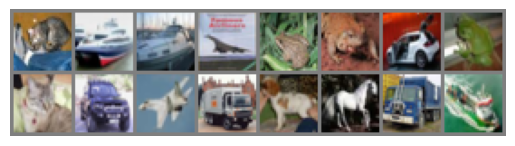

GroundTruth: cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship


In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]))  # Show first 16 images
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(16)))

## Using an AlexNet Classifier

### Imports

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

### Normalising and converting to tensors

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),     
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Resizing to 224x224 for AlexNet
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-defined AlexNet model
alexnet = models.alexnet(pretrained=False)

# Modify classifier to output 10 classes instead of 1000
alexnet.classifier[6] = nn.Linear(4096, 10)

alexnet = alexnet.to(device)

E:\Me\coding\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Me\coding\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)

In [9]:
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss / len(trainloader):.4f}")

Epoch 1 loss: 1.5320
Epoch 2 loss: 1.0557
Epoch 3 loss: 0.8402
Epoch 4 loss: 0.7003
Epoch 5 loss: 0.5905


### Evaluation

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 76.76%


### Visualise

In [1]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


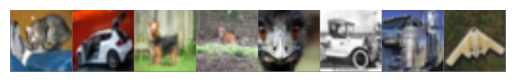

Wrong Labels:      cat car dog deer bird car truck plane
Wrong Predictions: dog cat deer bird cat truck horse horse


In [13]:
wrong_preds = []
wrong_labels = []
wrong_imgs = []

alexnet.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_imgs.append(images[i].cpu())
                wrong_preds.append(predicted[i].cpu())
                wrong_labels.append(labels[i].cpu())

        if len(wrong_imgs) >= 8:
            break

# Show 8 wrong predictions
imshow(torchvision.utils.make_grid(wrong_imgs[:8]))
print("Wrong Labels:     ", ' '.join(classes[wrong_labels[i]] for i in range(8)))
print("Wrong Predictions:", ' '.join(classes[wrong_preds[i]] for i in range(8)))

## Using a ResNet model (pretrained)

### Imports

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

### Normalising and Data-Loading

In [16]:
transform = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Load Model

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained ResNet18
resnet = models.resnet18(pretrained=True)

# Freeze all layers (optional)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last layer to match 10 classes (CIFAR-10)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)


E:\Me\coding\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\krjig/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 10.0MB/s]


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only training the last layer

In [19]:
epochs = 5

resnet.train()
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss / len(trainloader):.4f}")


Epoch 1 loss: 0.8286
Epoch 2 loss: 0.6187
Epoch 3 loss: 0.5870
Epoch 4 loss: 0.5742
Epoch 5 loss: 0.5660


### Visualisation

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

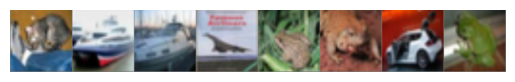

GroundTruth: cat ship ship plane frog frog car frog
Predicted:    cat ship ship plane frog frog truck frog


In [22]:
# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

# Move to device and get predictions
images = images.to(device)
resnet.eval()
with torch.no_grad():
    outputs = resnet(images)
    _, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))

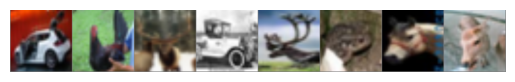

Wrong Labels:      car bird deer car deer frog horse deer
Wrong Predictions: truck cat cat truck plane bird cat dog


In [23]:
# Visualize wrong predictions
wrong_imgs = []
wrong_preds = []
wrong_labels = []

resnet.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_imgs.append(images[i].cpu())
                wrong_preds.append(predicted[i].cpu())
                wrong_labels.append(labels[i].cpu())

        if len(wrong_imgs) >= 8:
            break

# Show 8 wrong predictions
imshow(torchvision.utils.make_grid(wrong_imgs[:8]))
print("Wrong Labels:     ", ' '.join(classes[wrong_labels[i]] for i in range(8)))
print("Wrong Predictions:", ' '.join(classes[wrong_preds[i]] for i in range(8)))

## Using Pretrained Inception Model

### Imports

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

### Normalisation and Data-Loading

In [26]:
# Inception v3 needs 299x299 input
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Load Model

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pre-trained Inception v3
inception = models.inception_v3(pretrained=True, aux_logits=True)

# Freeze base layers (optional)
for param in inception.parameters():
    param.requires_grad = False

# Replace final layers to output 10 classes
inception.fc = nn.Linear(inception.fc.in_features, 10)
inception.AuxLogits.fc = nn.Linear(inception.AuxLogits.fc.in_features, 10)

inception = inception.to(device)


E:\Me\coding\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\krjig/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:10<00:00, 10.3MB/s] 


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inception.parameters(), lr=0.0005)

In [29]:
epochs = 5

inception.train()
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, aux_outputs = inception(images)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # weighted loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss / len(trainloader):.4f}")


Epoch 1 loss: 1.4419
Epoch 2 loss: 1.1648
Epoch 3 loss: 1.1361
Epoch 4 loss: 1.1174
Epoch 5 loss: 1.1159


### Visualisation

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


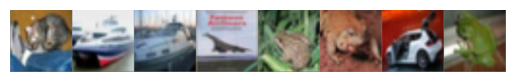

GroundTruth: cat ship ship plane frog frog car frog
Predicted:    cat ship ship truck frog frog car cat


In [31]:
# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

# Get predictions from Inception
images = images.to(device)
inception.eval()
with torch.no_grad():
    outputs = inception(images)  # Single output in eval mode
    _, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))

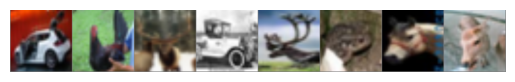

Wrong Labels:      car bird deer car deer frog horse deer
Wrong Predictions: truck cat cat truck plane bird cat dog


In [32]:
inception.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_imgs.append(images[i].cpu())
                wrong_preds.append(predicted[i].cpu())
                wrong_labels.append(labels[i].cpu())

        if len(wrong_imgs) >= 8:
            break

# Show wrong predictions
imshow(torchvision.utils.make_grid(wrong_imgs[:8]))
print("Wrong Labels:     ", ' '.join(classes[wrong_labels[i]] for i in range(8)))
print("Wrong Predictions:", ' '.join(classes[wrong_preds[i]] for i in range(8)))

## Provided a specific neural network architecture, train the CIFAR-10 dataset to classify

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # [32x32] → [32x32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # [32x32] → [16x16]
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # [16x16] → [8x8]
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.classifier(x)
        return x

In [36]:
model = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} loss: {running_loss / len(trainloader):.4f}")

Epoch 1 loss: 1.4698
Epoch 2 loss: 1.1097
Epoch 3 loss: 0.9567
Epoch 4 loss: 0.8649
Epoch 5 loss: 0.7906
Epoch 6 loss: 0.7272
Epoch 7 loss: 0.6723
Epoch 8 loss: 0.6211
Epoch 9 loss: 0.5772
Epoch 10 loss: 0.5374


### Evaluation

In [38]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 73.74%


### Visualisation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    # Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(8)))

# Predict
images = images.to(device)
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]}' for j in range(8)))